In [4]:
from sklearn.metrics import accuracy_score
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


sns.set_style("darkgrid")

# Домашнее задание

# 1 - Уменьшение палитры изображения (суммарно 6 баллов)
Для <a href='https://thumbs.dreamstime.com/x/two-lorikeet-birds-2293918.jpg'> картинки </a> нужно уменьшить число цветов в палитре.

Для этого нужно выделить **кластеры в пространстве RGB**, объекты соответствуют пикселям изображения. После выделения кластеров, все пиксели, отнесенные в один кластер, заполняются одним цветом; этот цвет может быть центроидом соответствующего кластера, медианным цветом по кластеру.

Попробуйте различные алгоритмы кластеризации:

* KMeans
* DBSCAN
* AgglomerativeClustering

Рассмотрите число кластеров K = 2, 3, 10, 20 (в алгоритмах, где есть такой гиперпараметр).

Для различных кластеризаций оцените и сравните потери от уменьшения цветов при помощи метрики 
<a href='http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim'> SSIM </a>. Какой способ оказался лучшим?

Задание оценивает в 5 баллов.

Еще 1 балл даётся за запуск алгоритма на выбранных вами картинках - на них результат должен получиться красивым.

Вот вам вспомогательные функции для считывания и вывода изображений:

In [79]:
def draw_picture(image, bgr=False):
    b, g, r = cv2.split(image) # по умолчанию cv2 почему-то отдает цвета в порядке BGR вместо RGB
    new_image = cv2.merge([r, g, b])
    plt.figure(figsize=(7, 5))
    plt.axis('off')
    plt.imshow(new_image)
    plt.show()

img - это обычный трехмерный массив цветов пикселей, где две первые координаты - это координаты каждого пикселя, и третья обозначает R, G или B.

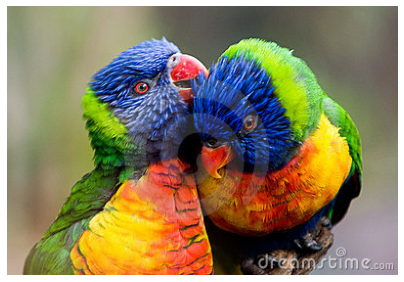

In [80]:
img = cv2.imread('birds.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [81]:
print(img.shape) # сам img - это обычный трехмерный массив 275 x 400 x 3
# вам скорее все кстати понадобится сделать reshape, чтобы перейти от 275x400 к одномерному массиву пикселей

(275, 400, 3)


In [82]:
orig_img = img / 255
image = orig_img.reshape(-1, 3)

In [83]:
def draw_pictures(orig_img, images, range_plot, name_sample, title=None, bgr=False):
    nrows = 2
    ncols = 2
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 7), constrained_layout=True)

    for image, k, i in zip(images, range_plot, np.arange(len(range_plot))):
        b, g, r = cv2.split(image)
        new_image = cv2.merge([r, g, b])

        ax[i // nrows, i % ncols].axis('off')
        ax[i // nrows, i % ncols].set_title(f"{name_sample} = {k} SSIM = {round(ssim(orig_img, image, multichannel=True), 3)}")
        ax[i // nrows, i % ncols].imshow(new_image)

    fig.suptitle(title)
    fig.tight_layout(pad=1.5)
    fig.show()

# K-Means

Для начала попробуем K-means с разным количеством кластеров:

In [84]:
ks = [2, 3, 10, 20]
images = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(image)
    new_image = kmeans.cluster_centers_[kmeans.labels_].reshape(img.shape)
    images.append(new_image)

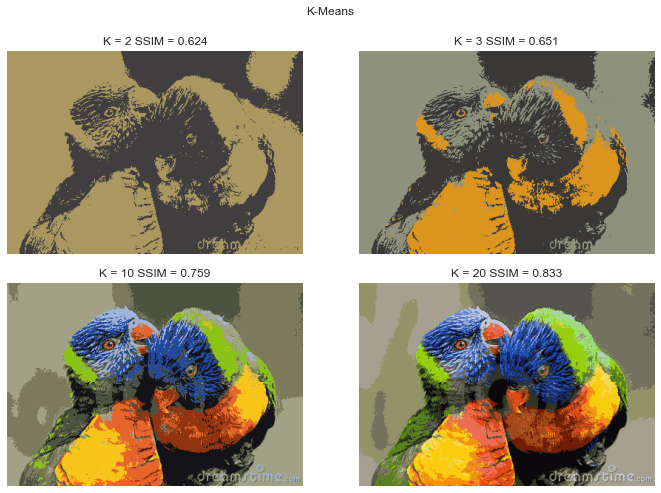

In [85]:
draw_pictures(orig_img, images, range_plot=ks, name_sample='K', title="K-Means")

У k = 10 и k = 20 результат получится хорошим, на остальных двух картинка получилась четкая и понятно, что на ней изображено, пусть без красочности. Посмотрим теперь в целом на метрику K-means score и заодно на SSIM подробнее на интервале для количества кластеров от 2 до 20

In [86]:
k_ssim = dict()

for k in np.arange(2, 21):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(image)
    new_image = kmeans.cluster_centers_[kmeans.labels_].reshape(img.shape)
    k_ssim[k] = [ssim(orig_img, new_image, multichannel=True), kmeans.inertia_]

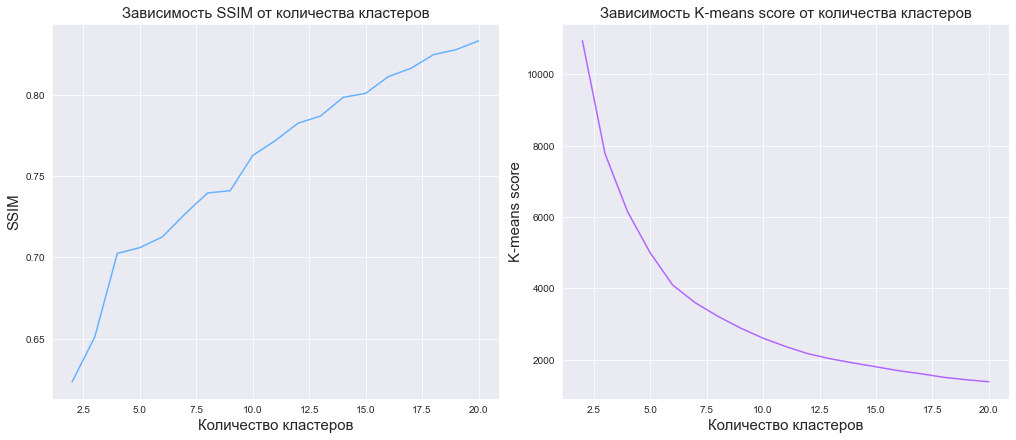

In [87]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), constrained_layout=True)

ax1.plot(list(k_ssim.keys()), [x[0] for x in k_ssim.values()], color='#66B2FF')
ax1.set_title("Зависимость SSIM от количества кластеров", fontsize=15)
ax1.set_xlabel("Количество кластеров", fontsize=15)
ax1.set_ylabel("SSIM", fontsize=15)

ax2.plot(list(k_ssim.keys()), [x[1] for x in k_ssim.values()], color='#B266FF')
ax2.set_title("Зависимость K-means score от количества кластеров", fontsize=15)
ax2.set_xlabel("Количество кластеров", fontsize=15)
ax2.set_ylabel("K-means score", fontsize=15)

fig.show()

K-means монотонно убывает и методом локтя нельзя определить нужное количество кластеров. SSIM растет, что тоже ожидаемо, судя по результатам выше.

# DBSCAN

Так как DBSCAN требователен, уменьшу размер изображения в 2 раза

In [88]:
reduce_img = resize(img, (img.shape[0] // 2, img.shape[1] // 2, 3), anti_aliasing=True)
image = reduce_img.reshape(-1, 3)

DBSCAN не имеет подобия центров как у K-means, но можно вычислить медианный цвет самостоятельно. Для этого я создала функцию mean_centres, она пригодится и для Agglomerative clustering.

In [89]:
def mean_centres(image, labels):
    centres = []
    for i in np.unique(labels):
        centres.append(np.median(image[labels == i], axis=0))
    return np.array(centres)

В качесте перебора вместо количества кластеров я взяла min_samples, epsilon выбрала подбором

In [90]:
min_samples = [1, 2, 4, 6]
images = []

for sample in min_samples:
    dbscan = DBSCAN(eps=0.01, min_samples=sample, n_jobs=-1)
    dbscan.fit(image)
    cluster_centers = mean_centres(image, dbscan.labels_)
    new_image = cluster_centers[dbscan.labels_].reshape(reduce_img.shape)
    images.append(new_image)

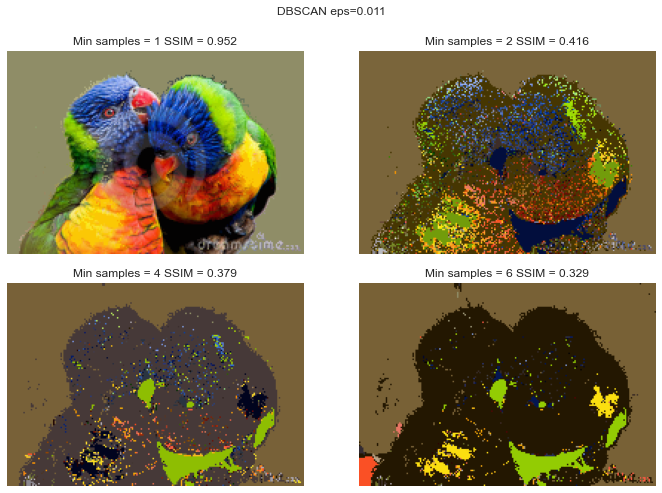

In [91]:
draw_pictures(reduce_img, images, min_samples, 'Min samples', 'DBSCAN eps=0.011')

При min_samples = 1, достигается лучший результат, однако в других случаях картинка очень шумная и не совсем понятно что на ней изображено. Так что в целом этот алгоритм пока проигрывает K-means

# Agglomerative clustering

Здесь для перебора я использовала linkages и количество кластеров

In [92]:
links = ['single', 'average', 'complete', 'ward']
ks = [2, 3, 10, 20]
images = {x : [] for x in links}

for link in links:
    for k in ks:
        aggclust = AgglomerativeClustering(n_clusters=k, linkage=link)
        aggclust.fit(image)
        cluster_centers = mean_centres(image, aggclust.labels_)
        new_image = cluster_centers[aggclust.labels_].reshape(reduce_img.shape)
        images[link].append(new_image)

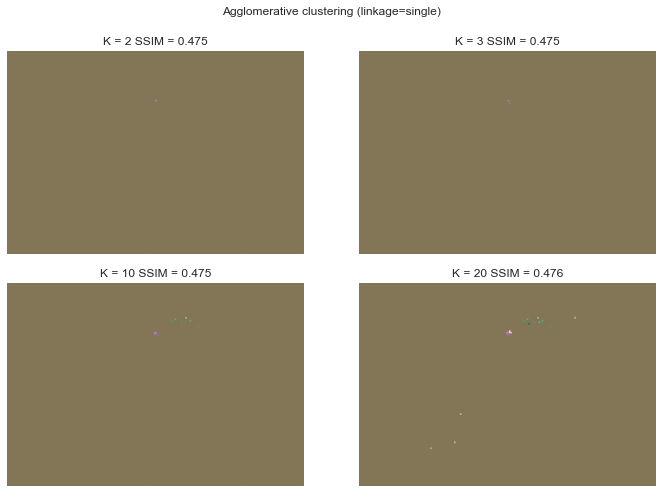

In [93]:
draw_pictures(reduce_img, images['single'], ks, 'K', 'Agglomerative clustering (linkage=single)')


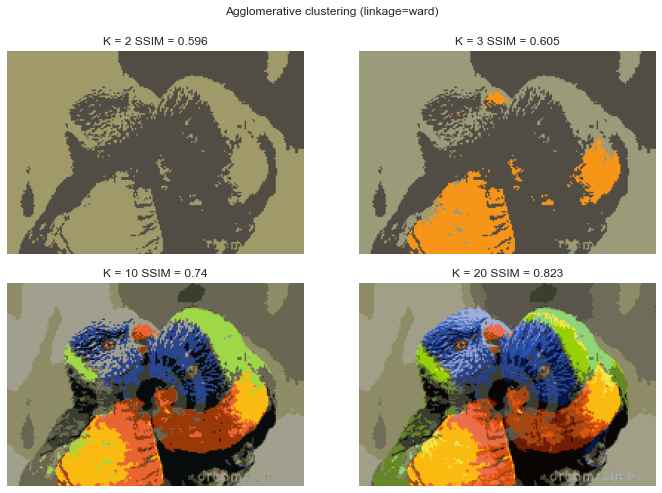

In [94]:
draw_pictures(reduce_img, images['ward'], ks, 'K', 'Agglomerative clustering (linkage=ward)')

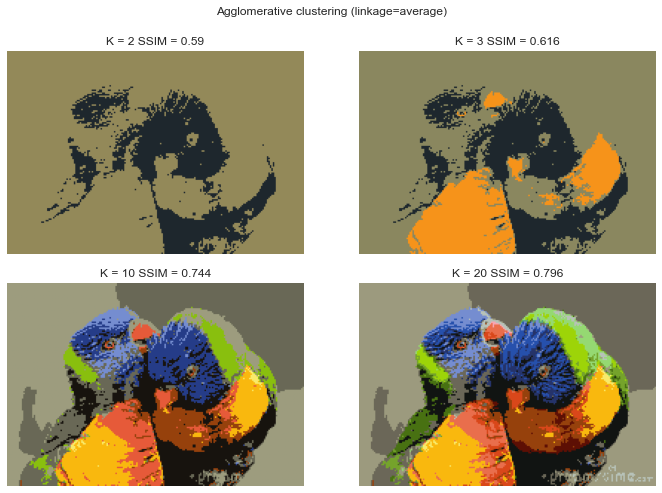

In [95]:
draw_pictures(reduce_img, images['average'], ks, 'K', 'Agglomerative clustering (linkage=average)')

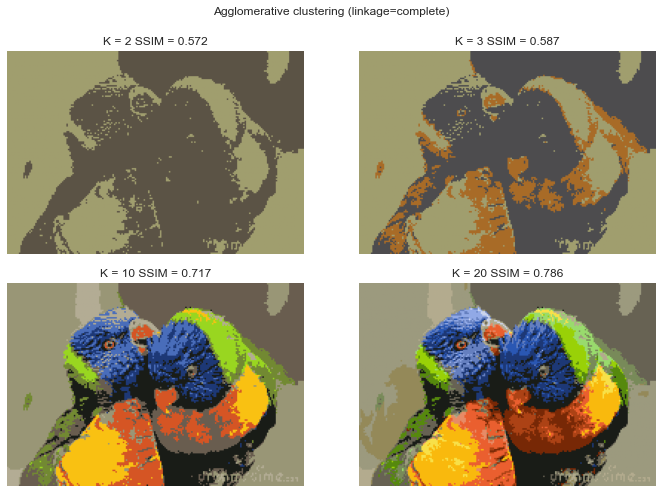

In [96]:
draw_pictures(reduce_img, images['complete'], ks, 'K', 'Agglomerative clustering (linkage=complete)')

- 'single' дал совсем плохой результат, ни одна картинка не отображает даже силуэт попугайчиков
- 'ward' справился получше, даже может создать конкуренцию K-means
- 'average' на 10 и 20 кластерах дал хороший результат, но на k = 2 попугайчиков можно не признать. Так же важно отметить, что здесь цвета красочнее. В остальных они немного темные
- 'complete' при больших количествах так же дал неплохой результат, однако при 2 и 3 много ненужных деталей, из-за которых картинка ставновится не совсем понятной

Выводы:
K-means в целом дал четкую (отчасти потому что размер мы не уменьшали) и красочную картинку. Так же если смотреть на SSIM, метрика на 2, 3, 10, 20 выше, чем у других алгоритмов. Исходя из этого, я считаю, что это лучший алгоритм для "сжатия красок"

# Мои картинки

Я возьму 3 картинки и на каждую буду использовать по одному алгоритму

## Котик из Шрека

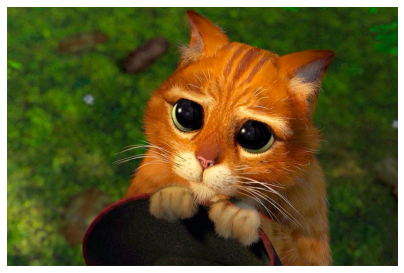

In [97]:
img = cv2.imread('cat.jpeg') # считать картинку
draw_picture(img) # нарисовать картинку

In [98]:
orig_img = img / 255
image = orig_img.reshape(-1, 3)

### K-means

In [100]:
ks = [2, 3, 10, 20]
images = []

for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(image)
    new_image = kmeans.cluster_centers_[kmeans.labels_].reshape(orig_img.shape)
    images.append(new_image)

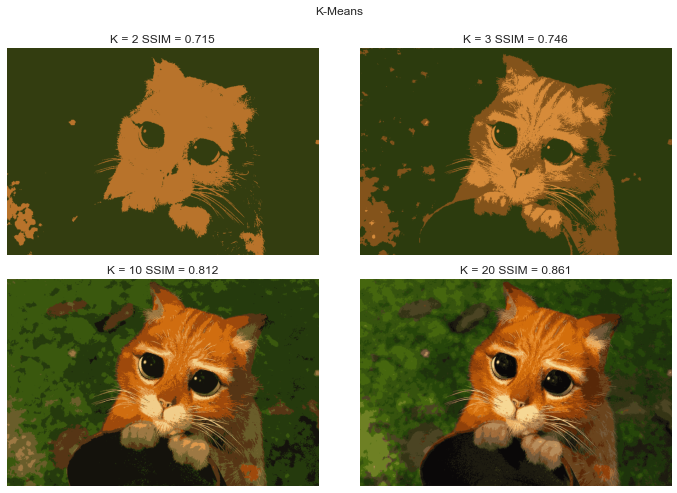

In [101]:
draw_pictures(orig_img, images, range_plot=ks, name_sample='K', title="K-Means")

K-means показал очень хороший результат! Везде котика можно узнать

## Шрек из Шрека

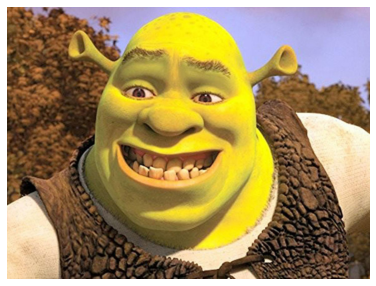

In [102]:
img = cv2.imread('shrek.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [103]:
img.shape

(864, 1152, 3)

In [104]:
reduce_img = resize(img, (img.shape[0] // 5, img.shape[1] // 5, 3), anti_aliasing=True)
image = reduce_img.reshape(-1, 3)

### DBSCAN

In [105]:
min_samples = [1, 2, 4, 6]
images = []

for sample in min_samples:
    dbscan = DBSCAN(eps=0.005, min_samples=sample, n_jobs=-1)
    dbscan.fit(image)
    cluster_centers = mean_centres(image, dbscan.labels_)
    new_image = cluster_centers[dbscan.labels_].reshape(reduce_img.shape)
    images.append(new_image)

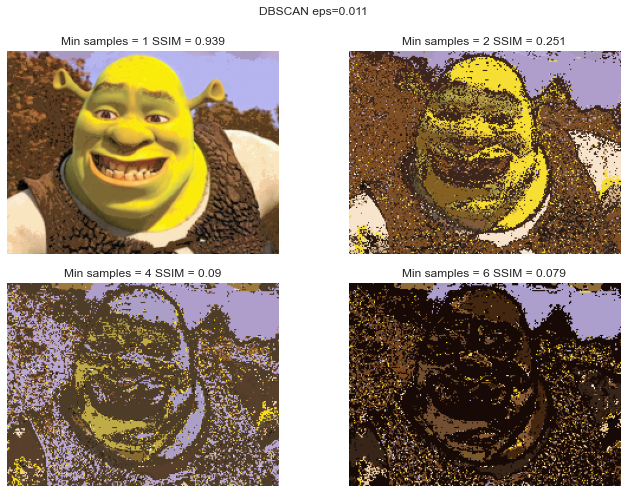

In [106]:
draw_pictures(reduce_img, images, min_samples, 'Min samples', 'DBSCAN eps=0.011')

DBSCAN в целом и на предыдущей картинке давал не совсем красивый результат, очень много шума, Шрек еле узнаваем на min samples 4

## Осел из Шрека

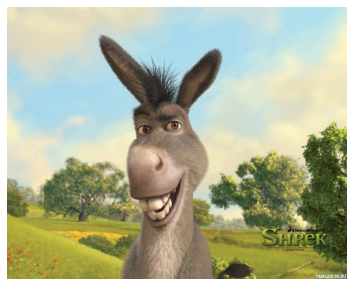

In [107]:
img = cv2.imread('osel.jpg') # считать картинку
draw_picture(img) # нарисовать картинку

In [108]:
img.shape

(560, 700, 3)

In [109]:
reduce_img = resize(img, (img.shape[0] // 4, img.shape[1] // 4, 3), anti_aliasing=True)
image = reduce_img.reshape(-1, 3)

### Agglomerative clustering

Так как на предыдущем пункте 'ward' дал лучший результат, буду использовать именно его

In [110]:
ks = [2, 3, 10, 20]
images = []

for k in ks:
    aggclust = AgglomerativeClustering(n_clusters=k)
    aggclust.fit(image)
    cluster_centers = mean_centres(image, aggclust.labels_)
    new_image = cluster_centers[aggclust.labels_].reshape(reduce_img.shape)
    images.append(new_image)

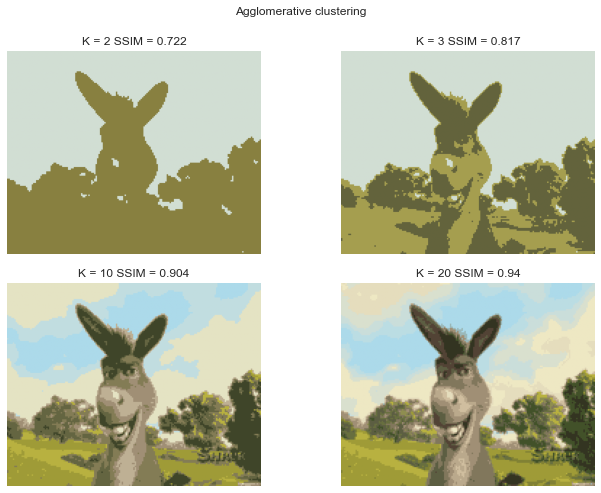

In [111]:
draw_pictures(reduce_img, images, ks, 'K', 'Agglomerative clustering')

Совсем плохо получилось на k=2, однако SSIM дает результат 0.722. В остальном осел виден и красочен

# 2 - Уменьшение размерности помогает классификации лиц (суммарно 6 баллов)

Используя методы уменьшения размерности признаков, решите с максимальным **accuracy** задачу классификации лиц знаменитостей (датасет старый, неудивительно, если вы из всех знаменитостей будете знать только Буша и Шварценнегера).

Попробуйте добиться максимального accuracy (2 балла)
* без уменьшения размерности
* с уменьшением размерности

Возможно без уменьшения размерности у вас даже просто не получится дождаться времени работы на 11750 признаках. Я слышал у кого-то получилось, у меня нет.

Сравните ваш результат с константным предсказанием "всегда самый популярный класс". Делает ли ваша модель какой-то значительный прогресс? (1 балл)

Нарисуйте несколько лиц, на которых ваш алгоритм ошибся, подпишите правильный ответ и ваш ответ. (1 балл)

Напишите, каким алгоритмом вы воспользовались (PCA или TSNE), почему не другим? Обоснуйте ответ. (1 балл)

Визуализируйте датасет на плоскости. Подпишите несколько самых больших классов именами людей. Чем вы воспользуетесь, PCA или TSNE? Обоснуйте ответ (1 балл)

Скачивание данных и вспомогательная функция визуализации лиц уже есть:

In [5]:
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=1.0)
# эту строчку менять нельзя, ресайзить нельзя

In [6]:
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

Масштабируем данные:

In [7]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=42)
# эту строчку тоже менять нельзя'

In [9]:
X.shape # 2370 лиц, каждый из них представляется вектором размера 11750

(2370, 11750)

In [10]:
y.shape

(2370,)

In [11]:
names[8] # в y лежат номера, а names переводит номер в имя

'George W Bush'

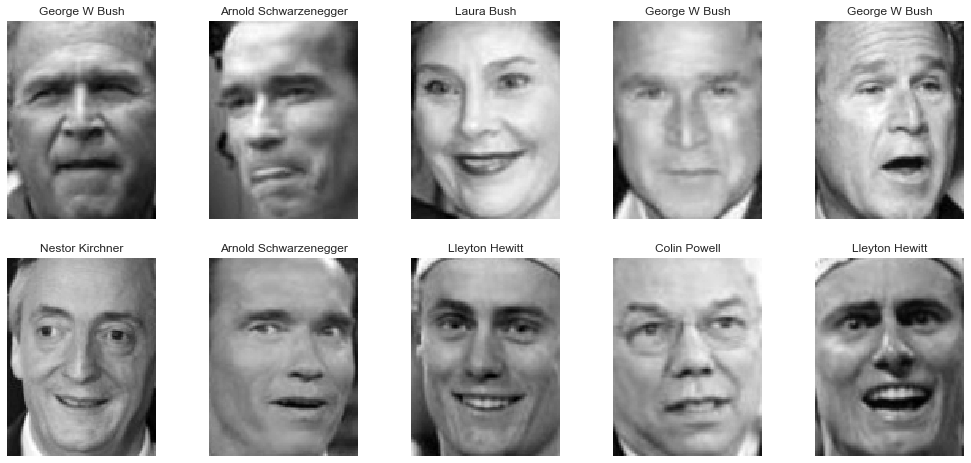

In [12]:
def plot_image(image_id):
    # функция рисует изображение номер image_id
    plt.title(names[y[image_id]])
    plt.imshow(255 - lfw_people['images'][image_id], cmap=plt.cm.gray_r, interpolation='nearest')
    
def plot_grid(image_ids, nrows, ncols):
    # функция рисует изображения с id равными image_ids
    # в nrows рядов и ncols столбцов
    fig = plt.gcf()
    fig.set_size_inches(17.5, 8)
    for index, example_id in enumerate(image_ids):
        plt.subplot(nrows, ncols, index + 1)
        plot_image(example_id)
        plt.axis('off')

plot_grid(range(10), nrows=2, ncols=5)# первые 10 лиц

Чтобы рисовать изображения, выделим фотографии в том же порядке (за это отвечает random_state=42) на train и test датасеты

In [13]:
X_image_train, X_image_test = train_test_split(lfw_people['images'], test_size=0.2, random_state=42)

In [14]:
def plot_errors(x_images, y_pred, y_true, nrows, ncols):
    fig = plt.gcf()
    fig.set_size_inches(20, 8)

    for i, image in enumerate(x_images):
        plt.subplot(nrows, ncols, i + 1)
        plt.title(f"{names[y_pred[i]]} ({names[y_true[i]]})")
        plt.imshow(255 - image, cmap=plt.cm.gray_r, interpolation='nearest')
        plt.axis('off')

Тут будут храниться результаты моделей:

In [15]:
models_score = dict()

# Уменьшение размерности

## PCA

### PCA 2 LogReg

Для начала возьмем 2 компоненты

In [16]:
pca = PCA(n_components=2, random_state=42)
X_pca_2_train = pca.fit_transform(X_train)

In [17]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_pca_2_train, y_train)
y_pred = logreg.predict(X_pca_2_train)
print("accuracy score on train (PCA_2): ", accuracy_score(y_train, y_pred))

accuracy score on train (PCA_2):  0.05063291139240506


Точность оказалась достаточно маленькой, что ожидаемо, так как из примерно из 11000 мы выбрали всего лишь 2 признака. Посмотрим на лица людей, которых наша модель определила неправильно. В скобках указан верный вариант.

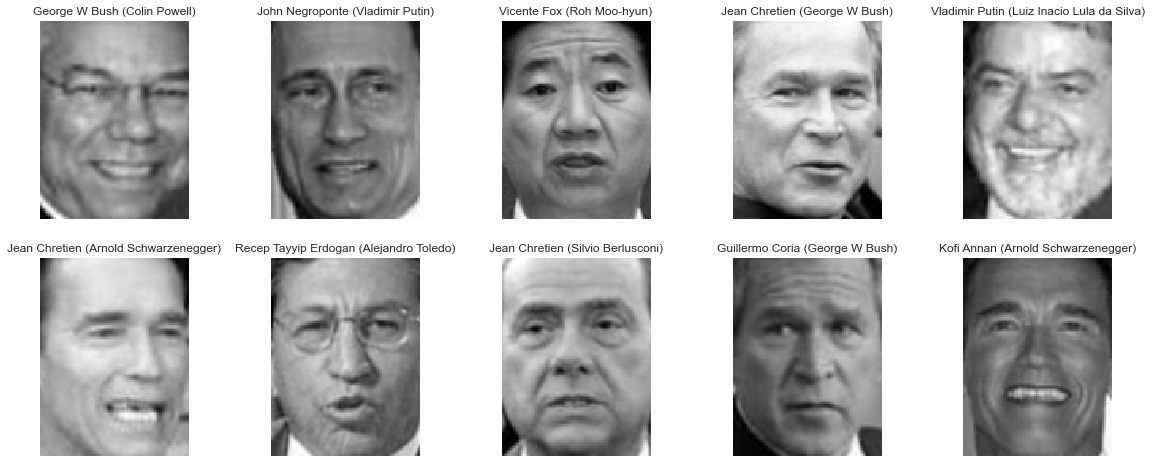

In [18]:
errors = np.where(y_pred != y_train)[0]
np.random.shuffle(errors)
errors = errors[:10]
plot_errors(X_image_train[errors], y_pred[errors], y_train[errors], nrows=2, ncols=5)

Попробуем подобрать лучшие гиперпараметры для модели:

In [19]:
params_logreg = {
    "penalty" : ['l1', 'l2', 'elasticnet', 'none'],
    "C" : np.arange(0, 1.1, 0.1),
    "class_weight" : ['balanced'],
    "solver" : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

In [20]:
search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=params_logreg,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)

search.fit(X_pca_2_train, y_train)
print(f"best params: {search.best_params_} best scoring: {search.best_score_}")

best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} best scoring: 0.143992501041522


Стало значительно лучше! Запишем результат.

In [21]:
models_score[f"logreg pca_2 {search.best_params_}"] = search.best_score_

### PCA 2 KNN

Проделаем то же самое только для классификатора KNN

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
knn = KNeighborsClassifier()
knn.fit(X_pca_2_train, y_train)
y_pred = knn.predict(X_pca_2_train)
print("accuracy score on train (PCA_2): ", accuracy_score(y_train, y_pred))

accuracy score on train (PCA_2):  0.3401898734177215


Здесь точность намного лучше.

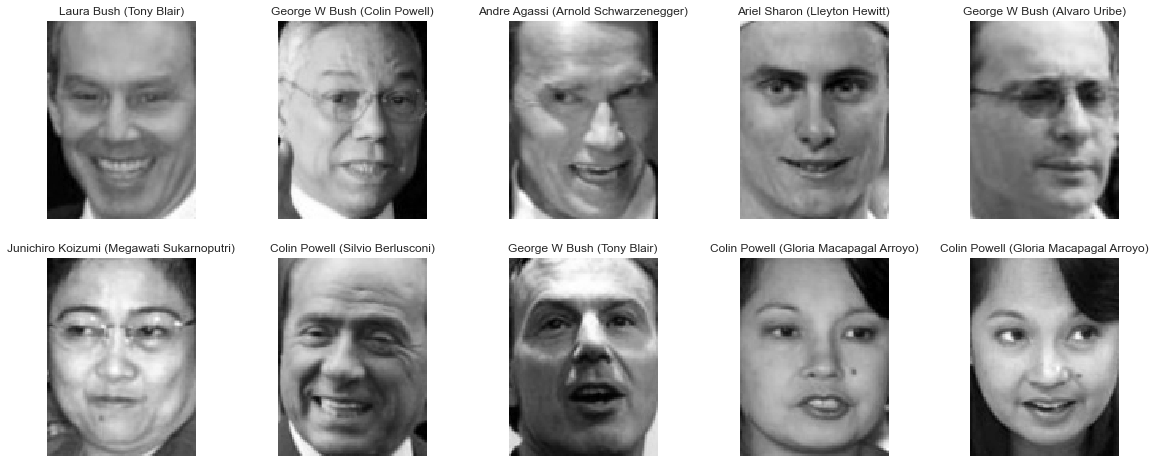

In [24]:
errors = np.where(y_pred != y_train)[0]
np.random.shuffle(errors)
errors = errors[:10]
plot_errors(X_image_train[errors], y_pred[errors], y_train[errors], nrows=2, ncols=5)

In [25]:
param_knn = {
    "n_neighbors" : np.arange(2, 6),
    "algorithm" : ['auto', 'ball_tree', 'kd_tree', 'brute'],
}

In [26]:
search = GridSearchCV(
    estimator=KNeighborsClassifier(n_jobs=-1),
    param_grid=param_knn,
    scoring='accuracy',
    n_jobs=-1,
    cv = 5
)
search.fit(X_pca_2_train, y_train)
print(f"best params: {search.best_params_} best scoring: {search.best_score_}")

best params: {'algorithm': 'auto', 'n_neighbors': 5} best scoring: 0.128697403138453


In [27]:
models_score[f"knn pca_2 {search.best_params_}"] = search.best_score_

### График кластеров на плоскости

Теперь построим плоскость с кластерами, выбрав 6 самых популярных людей.

In [28]:
from collections import Counter
popular_people = list(dict(Counter(y).most_common(6)).keys())

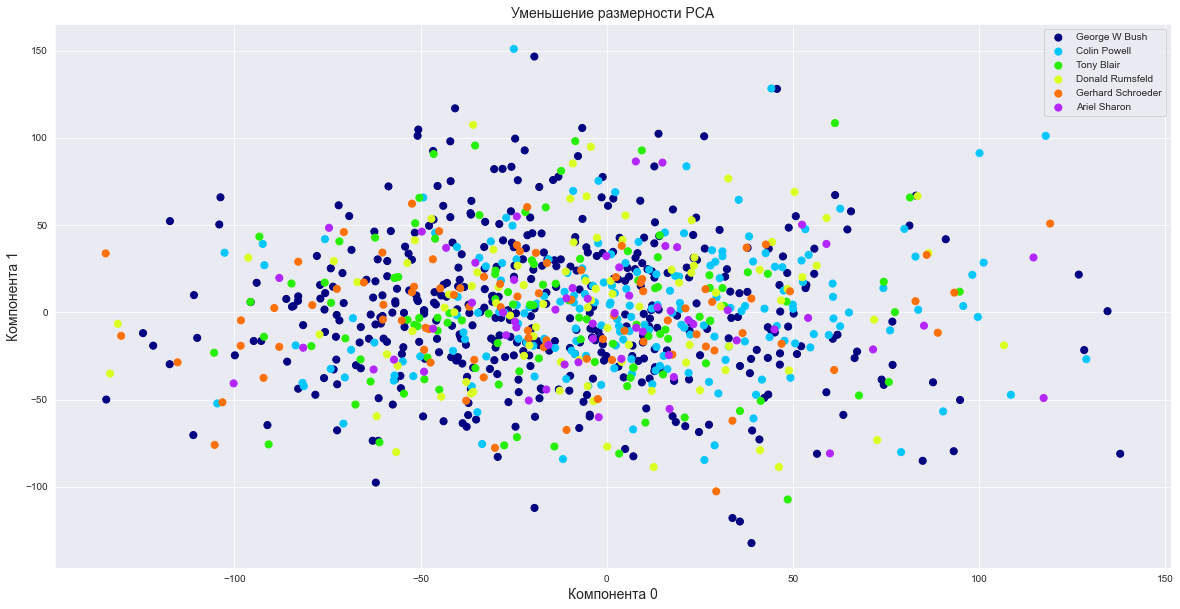

In [29]:
from matplotlib.colors import Normalize


plt.figure(figsize=(20, 10))

for i, d in enumerate(popular_people):
    norm = Normalize(vmin=0, vmax=6)
    color = plt.cm.gist_ncar(norm(i))
    plt.scatter(X_pca_2_train[:, 0][y_train == d],
                X_pca_2_train[:, 1][y_train == d],
                c=[color] * len(X_pca_2_train[:, 0][y_train == d]), label=names[d], edgecolor='face', s=50)

plt.title("Уменьшение размерности PCA", fontsize=14)
plt.xlabel("Компонента 0", fontsize=14)
plt.ylabel("Компонента 1", fontsize=14)
plt.legend()
plt.show()

Никакие кластеры, увы, не выделились. Все перемешано

### PCA best LogReg

Теперь определим лучшее количество кластеров, при котором accuracy максимально.

In [30]:
results = dict()

for i in range(2, 1000, 100):
    pca = PCA(n_components=i, random_state=42)
    X_new = pca.fit_transform(X_train)
    results[i] = np.mean(cross_val_score(
        LogisticRegression(class_weight='balanced', random_state=42), 
        X_new, 
        y_train, 
        scoring='accuracy'))

Определим количество компонент при максимальной точности:

In [31]:
max_accuracy_pca = max(results.items(), key=lambda x: x[1])

Я испытала на интервале

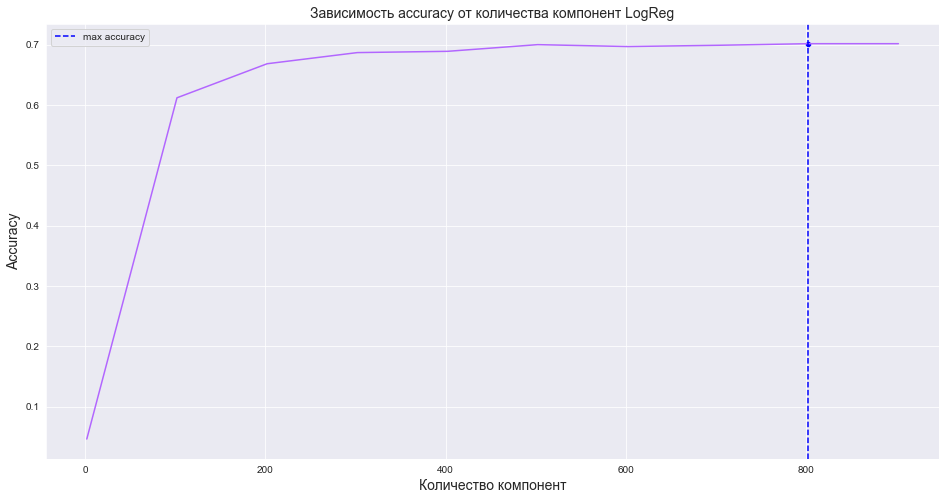

In [32]:
plt.figure(figsize=(16, 8))

sns.lineplot(x=list(results.keys()), y=list(results.values()), color="#B266FF")
sns.scatterplot(x=[max_accuracy_pca[0]], y=[max_accuracy_pca[1]], color='blue')
plt.axvline(max_accuracy_pca[0], ls='--', color='blue', label='max accuracy')

plt.title("Зависимость accuracy от количества компонент LogReg", fontsize=14)
plt.xlabel("Количество компонент", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()
plt.show()

Посотрим на лучший результат точнее:

In [33]:
max_accuracy_pca

(802, 0.7014747951673379)

In [34]:
pca = PCA(n_components=max_accuracy_pca[0], random_state=42)
X_pca_best_train = pca.fit_transform(X_train)

In [35]:
score = np.mean(cross_val_score(LogisticRegression(class_weight='balanced'), X_pca_best_train, y_train, scoring='accuracy', cv=5))
print(f"accuracy score on train (PCA_{max_accuracy_pca[0]}): ", score)

accuracy score on train (PCA_802):  0.7014747951673379


In [36]:
models_score[f"logreg pca_{max_accuracy_pca[0]}"] = score

### PCA best KNN

In [37]:
results = dict()

for i in range(2, 1000, 100):
    pca = PCA(n_components=i, random_state=42)
    X_new = pca.fit_transform(X_train)
    results[i] = np.mean(cross_val_score(KNeighborsClassifier(), X_new, y_train, scoring='accuracy'))

In [38]:
max_accuracy_pca = max(results.items(), key=lambda x: x[1])

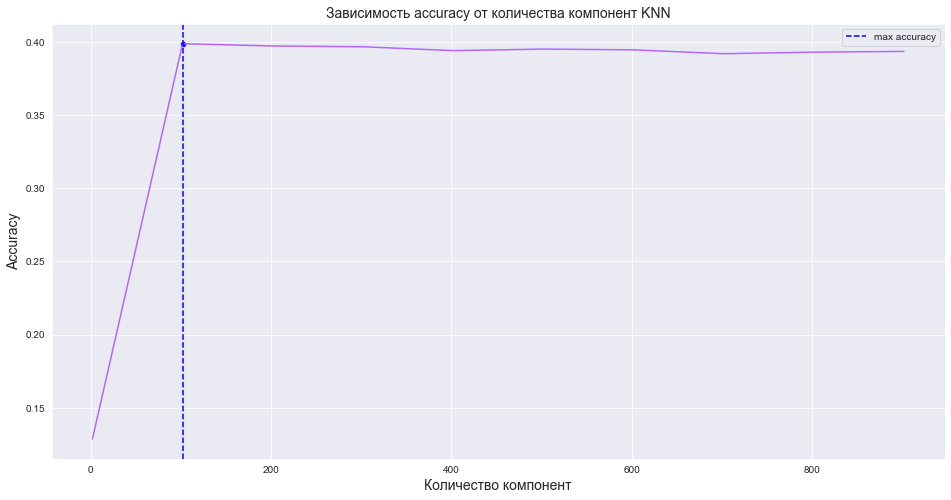

In [39]:
plt.figure(figsize=(16, 8))

sns.lineplot(x=list(results.keys()), y=list(results.values()), color="#B266FF")
sns.scatterplot(x=[max_accuracy_pca[0]], y=[max_accuracy_pca[1]], color='blue')
plt.axvline(max_accuracy_pca[0], ls='--', color='blue', label='max accuracy')

plt.title("Зависимость accuracy от количества компонент KNN", fontsize=14)
plt.xlabel("Количество компонент", fontsize=14)
plt.ylabel("Accuracy", fontsize=14)
plt.legend()
plt.show()

In [40]:
max_accuracy_pca

(102, 0.39871684488265513)

In [41]:
pca = PCA(n_components=max_accuracy_pca[0], random_state=42)
X_pca_best_train = pca.fit_transform(X_train)

In [42]:
score = np.mean(cross_val_score(KNeighborsClassifier(), X_pca_best_train, y_train, scoring='accuracy', cv=5))
print(f"accuracy score on train (PCA_{max_accuracy_pca[0]}): ", score)

accuracy score on train (PCA_102):  0.39871684488265513


In [43]:
models_score[f"knn pca_{max_accuracy_pca[0]}"] = score

## TSNE

### TSNE 2 LogReg

Теперь воспользуемся методом уменьшения размерности TSNE для 2 компонент

In [44]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne_2_train = tsne.fit_transform(X_train)

In [45]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_tsne_2_train, y_train)
y_pred = logreg.predict(X_tsne_2_train)
print("accuracy score on train (TSNE_2): ", accuracy_score(y_train, y_pred))

accuracy score on train (TSNE_2):  0.07436708860759493


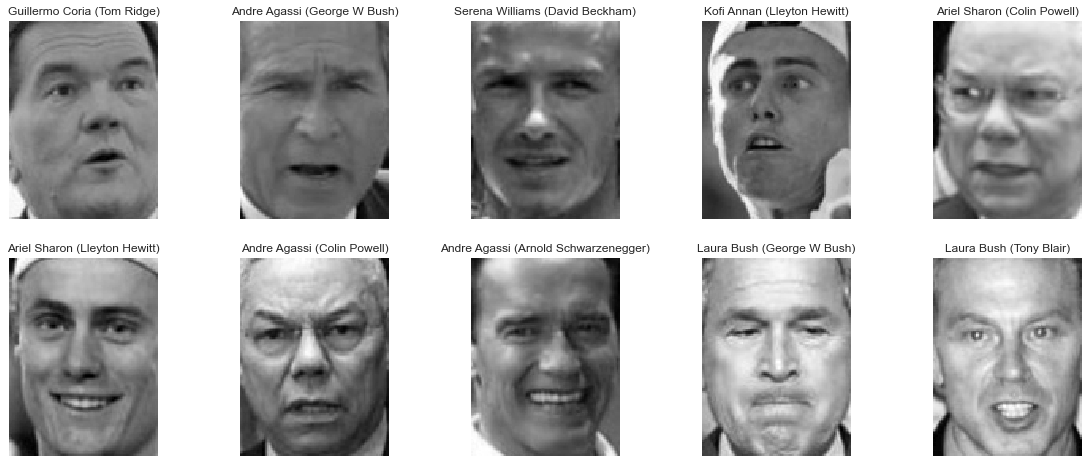

In [46]:
errors = np.where(y_pred != y_train)[0]
np.random.shuffle(errors)
errors = errors[:10]
plot_errors(X_image_train[errors], y_pred[errors], y_train[errors], nrows=2, ncols=5)

In [47]:
search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=params_logreg,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)

search.fit(X_tsne_2_train, y_train)
print(f"best params: {search.best_params_} best scoring: {search.best_score_}")

best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} best scoring: 0.11392306624079988


In [48]:
models_score[f"logreg tsne_2 {search.best_params_}"] = search.best_score_

### TSNE 2 KNN

In [49]:
knn = KNeighborsClassifier()
knn.fit(X_tsne_2_train, y_train)
y_pred = knn.predict(X_tsne_2_train)
print("accuracy score on train (TSNE_2): ", accuracy_score(y_train, y_pred))

accuracy score on train (TSNE_2):  0.5268987341772152


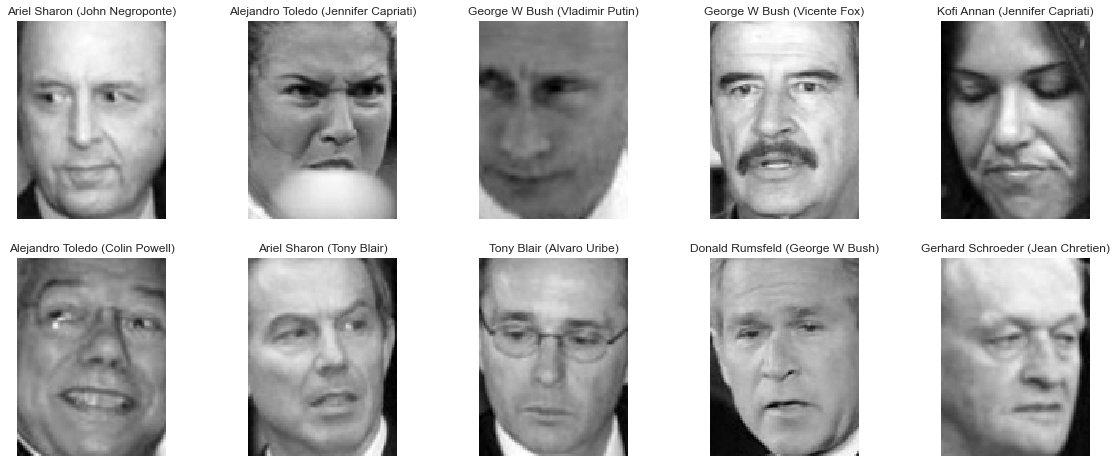

In [50]:
errors = np.where(y_pred != y_train)[0]
np.random.shuffle(errors)
errors = errors[:10]
plot_errors(X_image_train[errors], y_pred[errors], y_train[errors], nrows=2, ncols=5)

In [51]:
search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_knn,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)

search.fit(X_tsne_2_train, y_train)
print(f"best params: {search.best_params_} best scoring: {search.best_score_}")

best params: {'algorithm': 'auto', 'n_neighbors': 2} best scoring: 0.3344021663657825


In [52]:
models_score[f"knn tsne_2 {search.best_params_}"] = search.best_score_

### График кластеров на плоскости

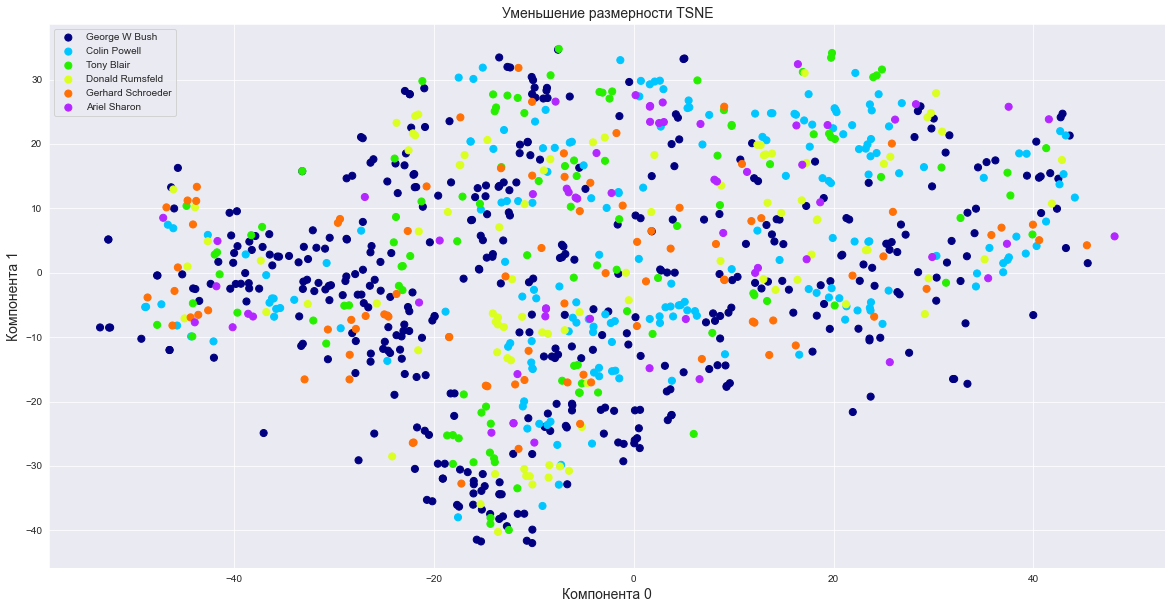

In [53]:
from matplotlib.colors import Normalize


plt.figure(figsize=(20, 10))

for i, d in enumerate(popular_people):
    norm = Normalize(vmin=0, vmax=6)
    color = plt.cm.gist_ncar(norm(i))
    plt.scatter(X_tsne_2_train[:, 0][y_train == d],
                X_tsne_2_train[:, 1][y_train == d],
                c=[color] * len(X_tsne_2_train[:, 0][y_train == d]), label=names[d], edgecolor='face', s=50)

plt.title("Уменьшение размерности TSNE", fontsize=14)
plt.xlabel("Компонента 0", fontsize=14)
plt.ylabel("Компонента 1", fontsize=14)
plt.legend()
plt.show()

Тут график выглядит кажется что даже немного лучше, потому что данные немного вытянуты и не собраны в одной точке. Но все еще они разбросаны везде

### TSNE 3 LogReg

Проделаем то же самое только для 3 компонент, так как TSNE может брать в себя только 2 или 3 компоненты

In [54]:
tsne = TSNE(n_components=3, random_state=42)
X_tsne_3_train = tsne.fit_transform(X_train)

In [55]:
logreg = LogisticRegression(class_weight='balanced', random_state=42)
logreg.fit(X_tsne_3_train, y_train)
y_pred = logreg.predict(X_tsne_3_train)
print("accuracy score on train (TSNE_3): ", accuracy_score(y_train, y_pred))

accuracy score on train (TSNE_3):  0.0770042194092827


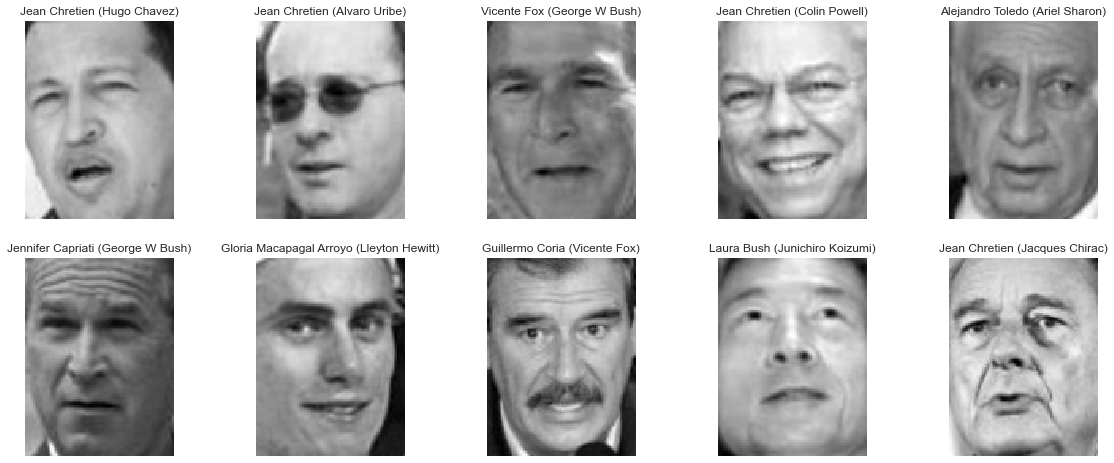

In [56]:
errors = np.where(y_pred != y_train)[0]
np.random.shuffle(errors)
errors = errors[:10]
plot_errors(X_image_train[errors], y_pred[errors], y_train[errors], nrows=2, ncols=5)

In [57]:
search = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=params_logreg,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)

search.fit(X_tsne_3_train, y_train)
print(f"best params: {search.best_params_} best scoring: {search.best_score_}")

best params: {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} best scoring: 0.10127204554922928


In [58]:
models_score[f"logreg tsne_3 {search.best_params_}"] = search.best_score_

### TSNE 3 KNN

In [59]:
knn = KNeighborsClassifier()
knn.fit(X_tsne_3_train, y_train)
y_pred = knn.predict(X_tsne_3_train)
print("accuracy score on train (TSNE_3): ", accuracy_score(y_train, y_pred))

accuracy score on train (TSNE_3):  0.5680379746835443


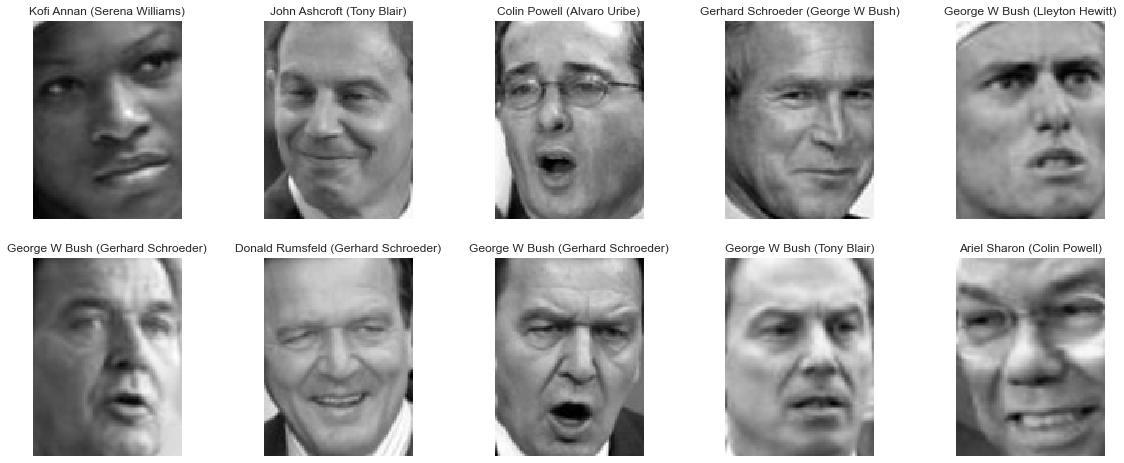

In [60]:
errors = np.where(y_pred != y_train)[0]
np.random.shuffle(errors)
errors = errors[:10]
plot_errors(X_image_train[errors], y_pred[errors], y_train[errors], nrows=2, ncols=5)

In [61]:
search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_knn,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
)

search.fit(X_tsne_3_train, y_train)
print(f"best params: {search.best_params_} best scoring: {search.best_score_}")

best params: {'algorithm': 'auto', 'n_neighbors': 5} best scoring: 0.34864741008193306


In [62]:
models_score[f"knn tsne_3 {search.best_params_}"] = search.best_score_

### График кластеров в пространстве

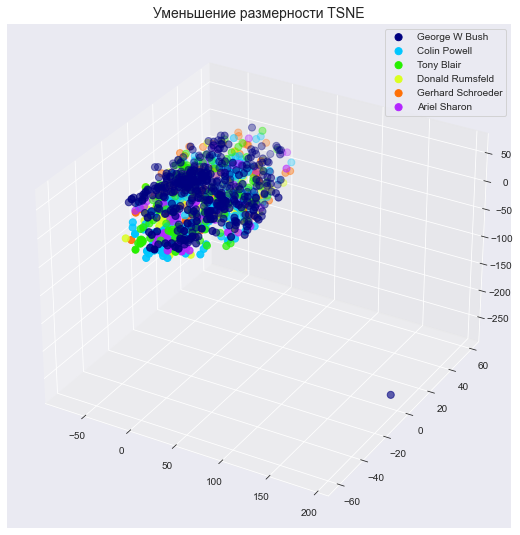

In [63]:
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 7))
ax = Axes3D(fig)

for i, d in enumerate(popular_people):
    norm = Normalize(vmin=0, vmax=6)
    color = plt.cm.gist_ncar(norm(i))
    ax.scatter(X_tsne_3_train[:, 0][y_train == d],
                X_tsne_3_train[:, 1][y_train == d],
                X_tsne_3_train[:, 2][y_train == d],
                c=[color] * len(X_tsne_3_train[:, 0][y_train == d]), label=names[d], edgecolor='face', s=50)

ax.set_title("Уменьшение размерности TSNE", fontsize=14)
plt.legend()
plt.show()

Тут все очень плохо, хотя с нашего ракурса можно заметить, что синие точки находятся ближе. Посмотрим на график 1 и 2 компоненты, отрезав выброс

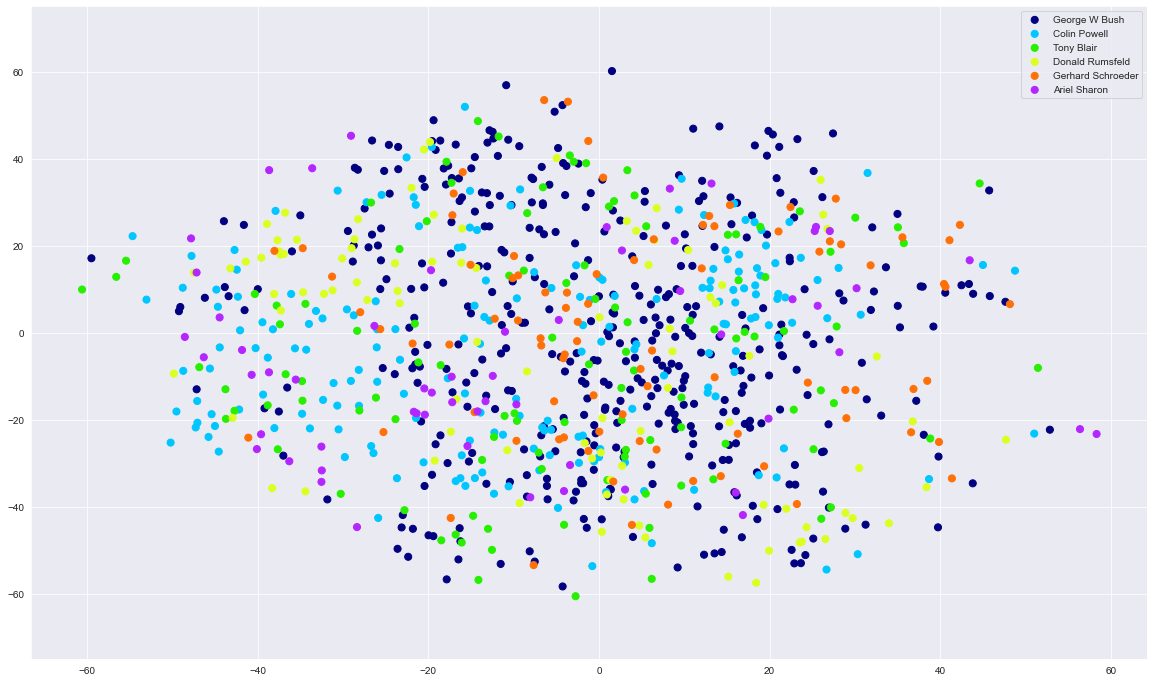

In [76]:
fig = plt.figure(figsize=(20, 12))

for i, d in enumerate(popular_people):
    norm = Normalize(vmin=0, vmax=6)
    color = plt.cm.gist_ncar(norm(i))
    plt.scatter(X_tsne_3_train[:, 1][y_train == d],
                X_tsne_3_train[:, 2][y_train == d],
                c=[color] * len(X_tsne_3_train[:, 0][y_train == d]), label=names[d], edgecolor='face', s=50)

ax.set_title("Уменьшение размерности TSNE", fontsize=14)
plt.legend()
plt.ylim(-75, 75)
plt.show()

Все еще смешано, однако можно заметить небольшой сдвиг темно-синих точек вправо. 
Но можно все это отнести к тому, что остальных данных просто поменьше.

Взглянем на результаты моделей с уменьшением размерности:

In [72]:
sorted(models_score.items(), key=lambda x: x[1])

[("logreg tsne_3 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}",
  0.10127204554922928),
 ("logreg tsne_2 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}",
  0.11392306624079988),
 ("knn pca_2 {'algorithm': 'auto', 'n_neighbors': 5}", 0.128697403138453),
 ("logreg pca_2 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}",
  0.143992501041522),
 ("knn tsne_2 {'algorithm': 'auto', 'n_neighbors': 2}", 0.3344021663657825),
 ("knn tsne_3 {'algorithm': 'auto', 'n_neighbors': 5}", 0.34864741008193306),
 ('knn pca_102', 0.39871684488265513),
 ('logreg pca_802', 0.7014747951673379)]

Пока самый максимум у logreg pca_802! Можно предположить, что чем больше признаков, тем точнее модель предсказывает

# Без уменьшения размерности

## Const

Посмотрим на самый поуплярный класс:

In [77]:
Counter(y_train).most_common(1)

[(8, 417)]

Обучим модель по константному классу:

In [78]:
y_pred = (np.ones(len(X_train)) * 8).astype(int)
print(f"accuracy score on train const: {accuracy_score(y_train, y_pred)}")

accuracy score on train const: 0.2199367088607595


Не сказать что точность очень высокая, это можно счесть на небольшое количество популярного класса. Из 2400 экземпляров 400 примерно 1/6 часть

In [79]:
models_score["const class"] = accuracy_score(y_train, y_pred)

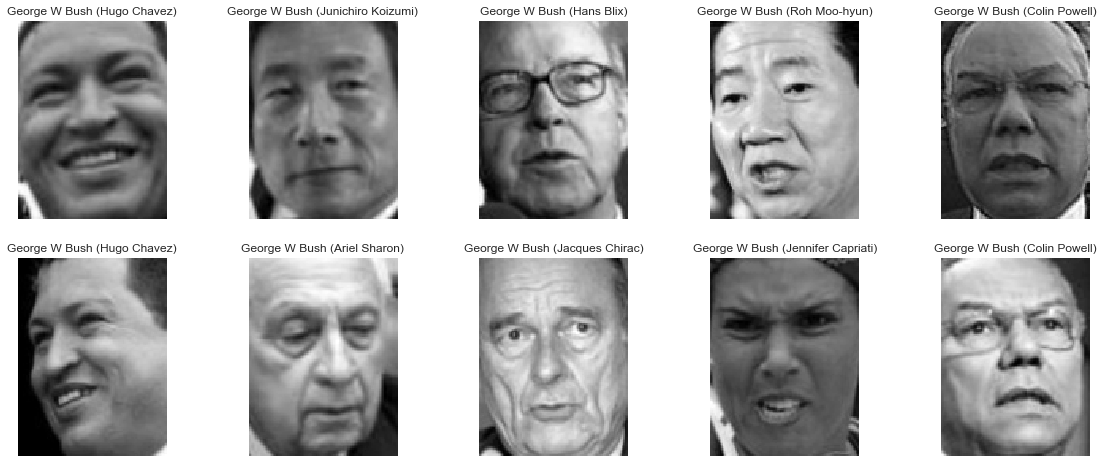

In [80]:
errors = np.where(y_pred != y_train)[0][:10]
plot_errors(X_image_train[errors], y_pred[errors], y_train[errors], nrows=2, ncols=5)

## LogReg

In [81]:
score = np.mean(cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=5, scoring="accuracy"))
print(f"accuracy score with original data train: {score}")

accuracy score with original data train: 0.7046354672962089


Очень высокая точность! Запишем

In [82]:
models_score[f"logreg original"] = score

## KNN

In [83]:
score = np.mean(cross_val_score(KNeighborsClassifier(), X_train, y_train, cv=5, scoring="accuracy"))
print(f"accuracy score with original data train: {score}")

accuracy score with original data train: 0.3929287598944591


KNN проигрывает LogReg

In [84]:
models_score[f"knn original"] = score

# Лучшая модель

In [85]:
sorted(models_score.items(), key=lambda x: x[1], reverse=True)

[('logreg original', 0.7046354672962089),
 ('logreg pca_802', 0.7014747951673379),
 ('knn pca_102', 0.39871684488265513),
 ('knn original', 0.3929287598944591),
 ("knn tsne_3 {'algorithm': 'auto', 'n_neighbors': 5}", 0.34864741008193306),
 ("knn tsne_2 {'algorithm': 'auto', 'n_neighbors': 2}", 0.3344021663657825),
 ('const class', 0.2199367088607595),
 ("logreg pca_2 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}",
  0.143992501041522),
 ("knn pca_2 {'algorithm': 'auto', 'n_neighbors': 5}", 0.128697403138453),
 ("logreg tsne_2 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}",
  0.11392306624079988),
 ("logreg tsne_3 {'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}",
  0.10127204554922928)]

Лучшая модель оказалась на модели без уменьшения размерности! Попробуем на тестовых данных:

In [86]:
best_model = LogisticRegression(class_weight='balanced')
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(f"accuracy score: {accuracy_score(y_test, y_pred)}")

accuracy score: 0.7257383966244726


**Выводы**
- PCA и TSNE не дали крутых визуальных результатов, графики получились смешанными, кластеры не выделились, но!
- TSNE 3 по двум компонентам можно заметить, что некоторые кластеры находятся левее или правее центра, так что для визуализации 5 попуялрных людей я бы выбрала TSNE 3 (и выбрала бы 2 компоненты)
- Уменьшение размерности не помогло улучшить accuracy_score
- В топ-5 можно заметить, что только knn tsne-3 теснится, то есть в среднем tsne не делал нашу модель лучше. Если бы все-таки приходилось выбирать алгоритм уменьшения размерности, то я бы выбрала PCA для LogReg и TSNE для KNN
